In [1]:
import sys
import sklearn


In [2]:
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [3]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "classification"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# MNIST

In [12]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)

C:\Users\rathn\.conda\envs\tf2\lib\site-packages\sklearn\datasets\_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [13]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [14]:
X, y = mnist.data, mnist.target
X.shape

(70000, 784)

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
     

### KNN Classifier training



In [8]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [9]:
y_pred = knn.predict(X_test)

In [10]:
# Print performance
from sklearn.metrics import classification_report, accuracy_score

print(f"Accuracy of the KNN clf: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Accuracy of the KNN clf: 0.9700714285714286
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1343
           1       0.96      0.99      0.98      1600
           2       0.98      0.96      0.97      1380
           3       0.97      0.97      0.97      1433
           4       0.97      0.97      0.97      1295
           5       0.97      0.97      0.97      1273
           6       0.98      0.99      0.98      1396
           7       0.96      0.97      0.97      1503
           8       0.99      0.93      0.96      1357
           9       0.95      0.96      0.96      1420

    accuracy                           0.97     14000
   macro avg       0.97      0.97      0.97     14000
weighted avg       0.97      0.97      0.97     14000



## Confusion matrix

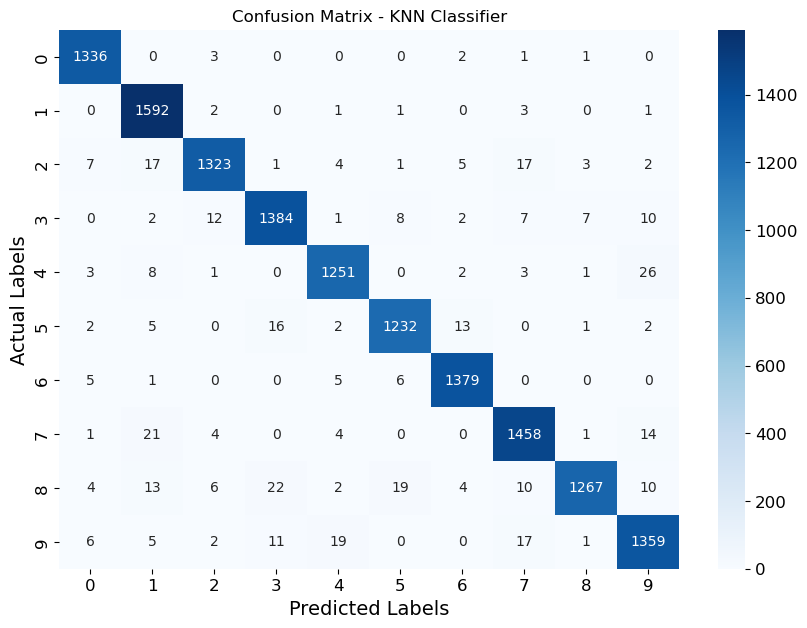

In [16]:
# Confusion matrix
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
conf_matrix = confusion_matrix(y_test, y_pred)


# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title("Confusion Matrix - KNN Classifier")
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

## KNN Hyperparameters Tuning

In [22]:
from sklearn.model_selection import train_test_split

# Use a smaller subset of training data for faster hyperparameter tuning
X_train_sub, _, y_train_sub, _ = train_test_split(X_train, y_train, train_size=0.2, random_state=42)
     
knn = KNeighborsClassifier()
from sklearn.model_selection import GridSearchCV
# Define the parameter grid
param_grid = {
    'n_neighbors': [3, 4, 5, 6, 7],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']

}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=3, scoring='accuracy', verbose=2)
grid_search.fit(X_train, y_train)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=  13.3s
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=  13.8s
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=  18.7s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=  20.5s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=  20.8s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=  21.1s
[CV] END ...metric=euclidean, n_neighbors=4, weights=uniform; total time=  26.4s
[CV] END ...metric=euclidean, n_neighbors=4, weights=uniform; total time=  26.5s
[CV] END ...metric=euclidean, n_neighbors=4, weights=uniform; total time=  25.4s
[CV] END ..metric=euclidean, n_neighbors=4, weights=distance; total time=  24.9s
[CV] END ..metric=euclidean, n_neighbors=4, weights=distance; total time=  23.1s
[CV] END ..metric=euclidean, n_neighbors=4, weig

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [3, 4, 5, 6, 7],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy', verbose=2)

In [23]:
print("Best Hyperparameters:", grid_search.best_params_)
best_knn = grid_search.best_estimator_

y_pred = best_knn.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Best Hyperparameters: {'metric': 'euclidean', 'n_neighbors': 4, 'weights': 'distance'}
Accuracy: 0.9731428571428572
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1343
           1       0.96      0.99      0.98      1600
           2       0.98      0.96      0.97      1380
           3       0.97      0.97      0.97      1433
           4       0.97      0.97      0.97      1295
           5       0.97      0.97      0.97      1273
           6       0.98      0.99      0.99      1396
           7       0.96      0.98      0.97      1503
           8       0.99      0.94      0.96      1357
           9       0.95      0.96      0.96      1420

    accuracy                           0.97     14000
   macro avg       0.97      0.97      0.97     14000
weighted avg       0.97      0.97      0.97     14000



### Confusion matrix - KNN Classifier('metric': 'euclidean', 'n_neighbors': 4, 'weights': 'distance')

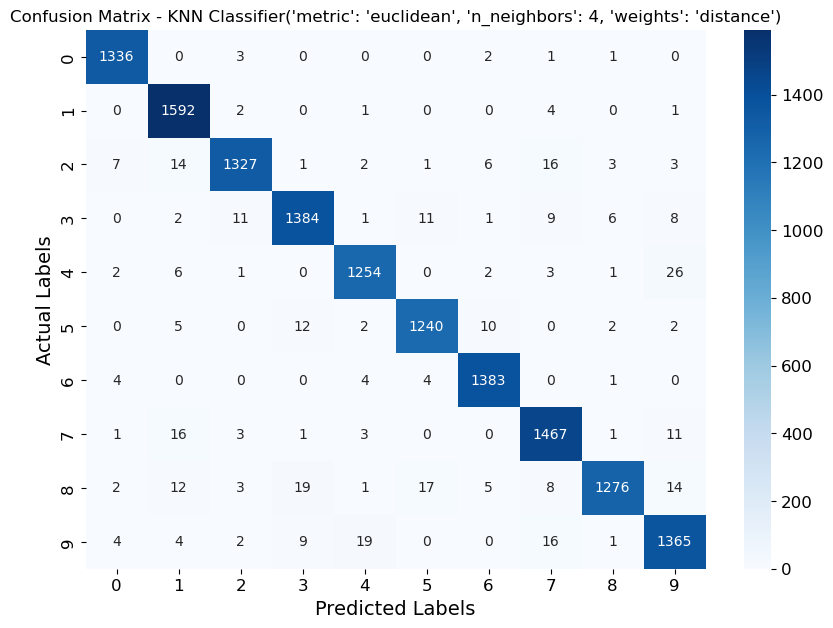

In [ ]:
# Confusion matrix
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
conf_matrix = confusion_matrix(y_test, y_pred)


# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title("Confusion Matrix - KNN Classifier('metric': 'euclidean', 'n_neighbors': 4, 'weights': 'distance')")
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

In [28]:
knn_cnf=conf_matrix
knn_cnf

array([[1336,    0,    3,    0,    0,    0,    2,    1,    1,    0],
       [   0, 1592,    2,    0,    1,    0,    0,    4,    0,    1],
       [   7,   14, 1327,    1,    2,    1,    6,   16,    3,    3],
       [   0,    2,   11, 1384,    1,   11,    1,    9,    6,    8],
       [   2,    6,    1,    0, 1254,    0,    2,    3,    1,   26],
       [   0,    5,    0,   12,    2, 1240,   10,    0,    2,    2],
       [   4,    0,    0,    0,    4,    4, 1383,    0,    1,    0],
       [   1,   16,    3,    1,    3,    0,    0, 1467,    1,   11],
       [   2,   12,    3,   19,    1,   17,    5,    8, 1276,   14],
       [   4,    4,    2,    9,   19,    0,    0,   16,    1, 1365]],
      dtype=int64)

## Random Forest Classification

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_predict

# Create a Random Forest classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(rf_clf, X_train, y_train, cv=3,
                                    method="predict_proba")

# Train the classifier
rf_clf.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf_clf.predict(X_test)
# Print performance metrics
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf)}")
print(classification_report(y_test, y_pred_rf))


Accuracy: 0.9672857142857143
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1343
           1       0.98      0.98      0.98      1600
           2       0.95      0.97      0.96      1380
           3       0.96      0.95      0.96      1433
           4       0.96      0.97      0.97      1295
           5       0.97      0.96      0.97      1273
           6       0.98      0.98      0.98      1396
           7       0.97      0.97      0.97      1503
           8       0.96      0.95      0.96      1357
           9       0.96      0.95      0.95      1420

    accuracy                           0.97     14000
   macro avg       0.97      0.97      0.97     14000
weighted avg       0.97      0.97      0.97     14000



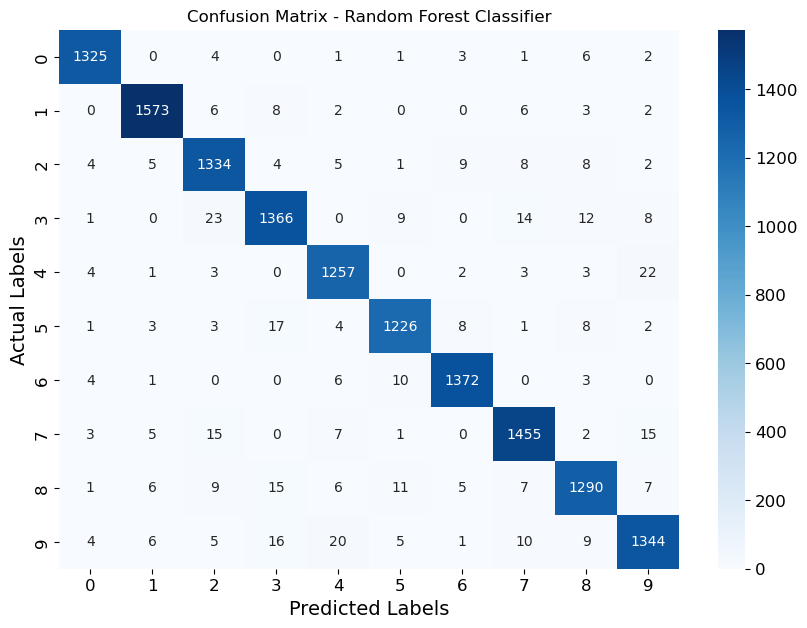

In [30]:

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
# Confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)


# Plot confusion matrix

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title("Confusion Matrix - Random Forest Classifier")
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

In [31]:
conf_matrix_rf

array([[1325,    0,    4,    0,    1,    1,    3,    1,    6,    2],
       [   0, 1573,    6,    8,    2,    0,    0,    6,    3,    2],
       [   4,    5, 1334,    4,    5,    1,    9,    8,    8,    2],
       [   1,    0,   23, 1366,    0,    9,    0,   14,   12,    8],
       [   4,    1,    3,    0, 1257,    0,    2,    3,    3,   22],
       [   1,    3,    3,   17,    4, 1226,    8,    1,    8,    2],
       [   4,    1,    0,    0,    6,   10, 1372,    0,    3,    0],
       [   3,    5,   15,    0,    7,    1,    0, 1455,    2,   15],
       [   1,    6,    9,   15,    6,   11,    5,    7, 1290,    7],
       [   4,    6,    5,   16,   20,    5,    1,   10,    9, 1344]],
      dtype=int64)

## SGD Classifer

In [32]:

from sklearn.linear_model import SGDClassifier
# Create an SGD classifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)

# Train the classifier
sgd_clf.fit(X_train, y_train)

# Predict on the test set
y_pred_sgd = sgd_clf.predict(X_test)
# Print performance metrics
print(f"Accuracy: {accuracy_score(y_test, y_pred_sgd)}")
print(classification_report(y_test, y_pred_sgd))

Accuracy: 0.8717142857142857
              precision    recall  f1-score   support

           0       0.99      0.90      0.95      1343
           1       0.96      0.98      0.97      1600
           2       0.84      0.88      0.86      1380
           3       0.88      0.84      0.86      1433
           4       0.97      0.71      0.82      1295
           5       0.84      0.84      0.84      1273
           6       0.92      0.95      0.94      1396
           7       0.88      0.94      0.91      1503
           8       0.84      0.74      0.79      1357
           9       0.69      0.90      0.78      1420

    accuracy                           0.87     14000
   macro avg       0.88      0.87      0.87     14000
weighted avg       0.88      0.87      0.87     14000



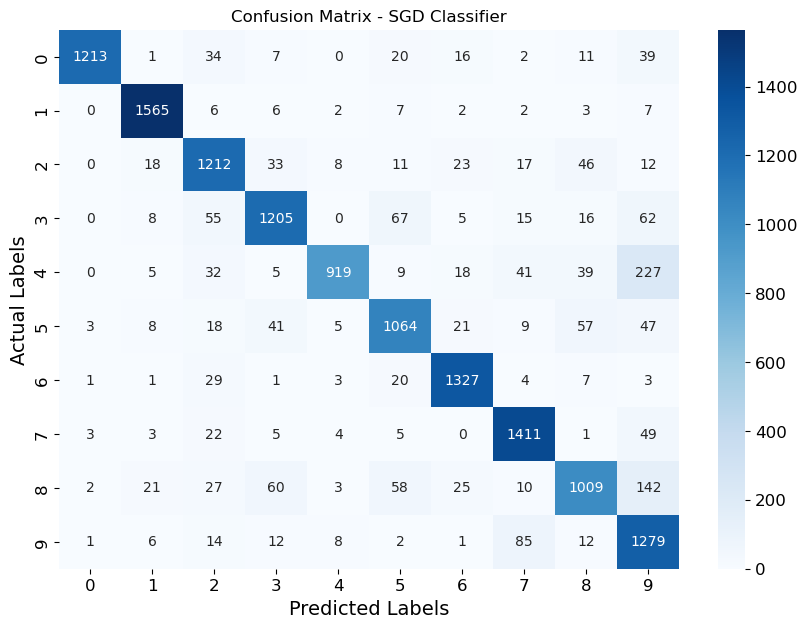

In [33]:

# Confusion matrix
conf_matrix_sgd = confusion_matrix(y_test, y_pred_sgd)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_sgd, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title("Confusion Matrix - SGD Classifier")
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()
     

In [34]:
conf_matrix_sgd

array([[1213,    1,   34,    7,    0,   20,   16,    2,   11,   39],
       [   0, 1565,    6,    6,    2,    7,    2,    2,    3,    7],
       [   0,   18, 1212,   33,    8,   11,   23,   17,   46,   12],
       [   0,    8,   55, 1205,    0,   67,    5,   15,   16,   62],
       [   0,    5,   32,    5,  919,    9,   18,   41,   39,  227],
       [   3,    8,   18,   41,    5, 1064,   21,    9,   57,   47],
       [   1,    1,   29,    1,    3,   20, 1327,    4,    7,    3],
       [   3,    3,   22,    5,    4,    5,    0, 1411,    1,   49],
       [   2,   21,   27,   60,    3,   58,   25,   10, 1009,  142],
       [   1,    6,   14,   12,    8,    2,    1,   85,   12, 1279]],
      dtype=int64)

Recall

C:\Users\rathn\.conda\envs\tf2\lib\site-packages\sklearn\datasets\_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


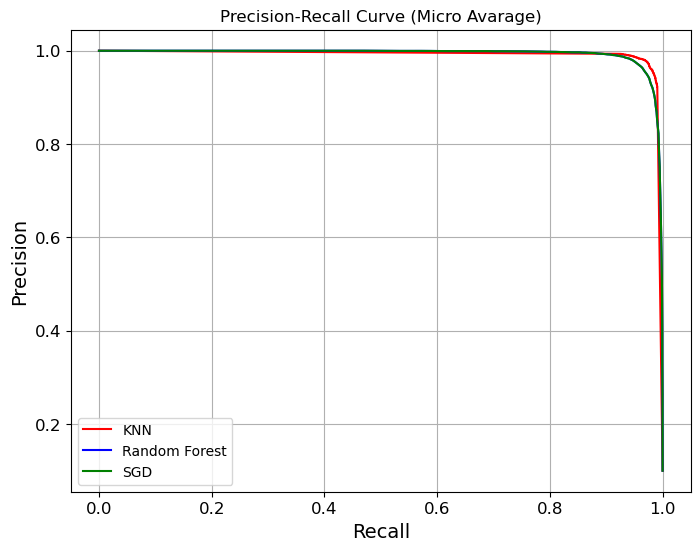

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.model_selection import train_test_split

# 1. Load MNIST dataset
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist.data, mnist.target
y = y.astype(int)  # Convert labels to integers

# 2. Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Define and train KNN classifier
clf = KNeighborsClassifier(metric= 'euclidean', n_neighbors= 4, weights= 'distance')
clf.fit(X_train, y_train)

# 4. Predict probabilities for the test set
y_score = clf.predict_proba(X_test)

# 5. Compute Precision-Recall and Average Precision for micro-averaging
# Binarize the test labels for computing metrics
from sklearn.preprocessing import label_binarize
y_test_bin = label_binarize(y_test, classes=np.arange(10))

precision, recall, _ = precision_recall_curve(y_test_bin.ravel(), y_score.ravel())
average_precision = average_precision_score(y_test_bin, y_score, average="micro")


plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label="KNN", color='r')


clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_score = clf.predict_proba(X_test)
from sklearn.preprocessing import label_binarize
y_test_bin = label_binarize(y_test, classes=np.arange(10))

precision, recall, _ = precision_recall_curve(y_test_bin.ravel(), y_score.ravel())
average_precision = average_precision_score(y_test_bin, y_score, average="micro")

plt.plot(recall, precision, label="Random Forest", color='b')

clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
clf.fit(X_train, y_train)

# 4. Get decision scores for the test set
y_scores = clf.decision_function(X_test)

# 5. Compute Precision-Recall curve and Average Precision score (micro-averaged)
precision, recall, _ = precision_recall_curve(y_test_bin.ravel(), y_score.ravel())
average_precision = average_precision_score(y_test_bin, y_score, average="micro")

plt.plot(recall, precision, color='g', label="SGD")

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Micro Avarage)')
plt.legend(loc='lower left')
plt.grid()
plt.show()
